
--- Forward Analysis: find what indices are doing when ACC>0.5 ---
Number of Matches: 107
ENSO: 0.020125680340335052
Soil Moisture: -0.1818691588785047
Weather Regime: 3
MJO phase: 6

--- Reverse Analysis ---
Number of Matches: 4
Average ACC for matched conditions: -0.055


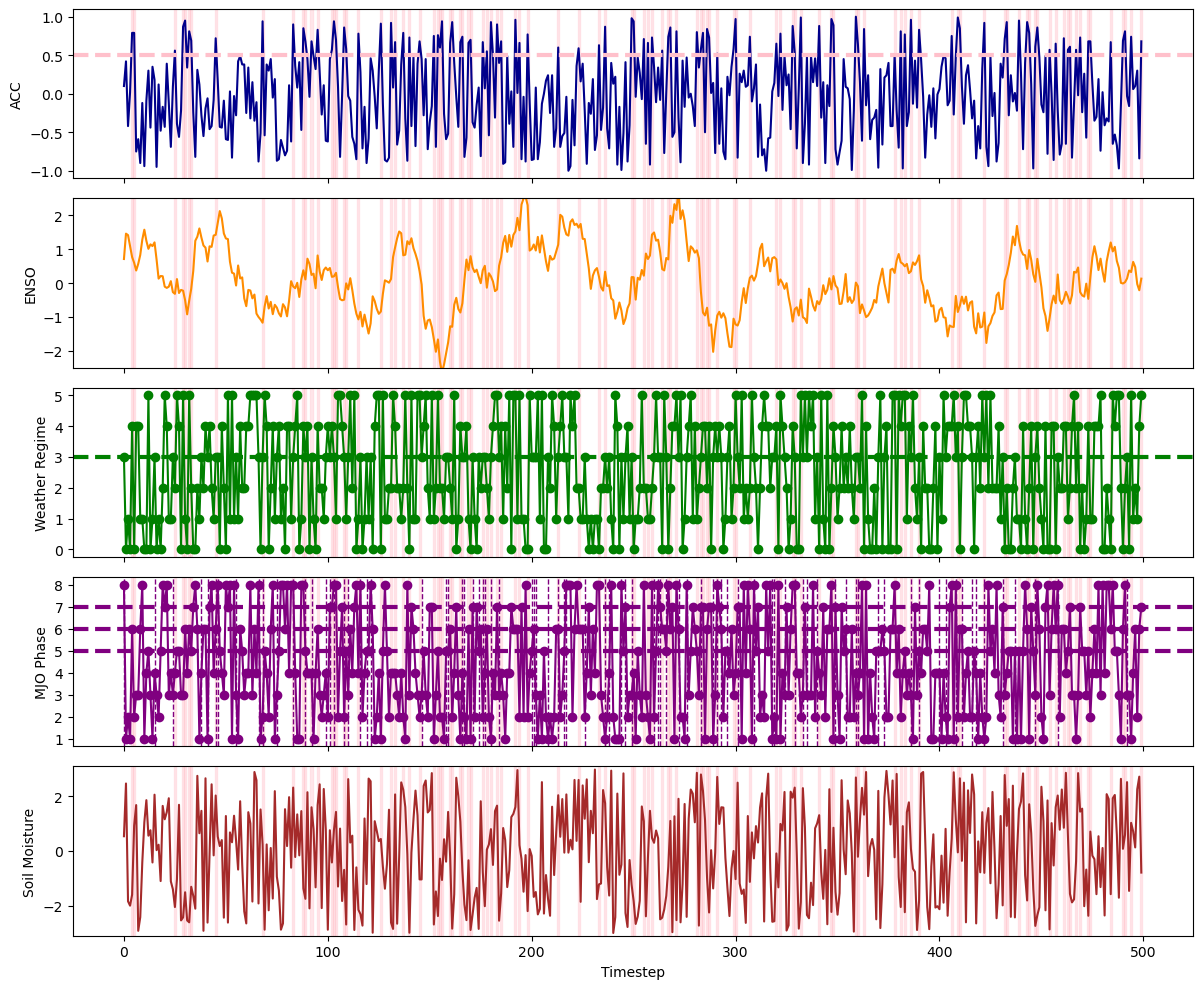

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(3)  # Set seed for reproducibility
n = 500
time = np.arange(n)
acc = np.round(np.random.uniform(-1, 1, n), 2)
enso = pd.Series(np.random.normal(0, 4, n)).rolling(window=15, center=True, min_periods=1).mean()
regime = np.random.randint(0, 6, n)
mjo = np.random.randint(1, 9, n)
soil = np.round(np.random.uniform(-3, 3, n), 2)

accWant = 0.5
num_events = np.sum(acc > accWant)
enso_capture = enso[acc > accWant].mean()
soil_capture = soil[acc > accWant].mean()
regime_capture = np.bincount(regime[acc > accWant]).argmax()
mjo_capture = np.bincount(mjo[acc > accWant]).argmax()
print("\n--- Forward Analysis: find what indices are doing when ACC>0.5 ---")
print("Number of Matches:", num_events)
print("ENSO:", enso_capture)
print("Soil Moisture:", soil_capture)
print("Weather Regime:", regime_capture)
print("MJO phase:", mjo_capture)

# ----------------------- reverse composite -----------------------
mask = ((np.abs(enso - enso_capture) <= 1) &
    (np.abs(soil - soil_capture) <= 1) &
    (regime == regime_capture) &
    (np.abs(mjo - mjo_capture) <= 1) )
acc_filtered = acc[mask]
print("\n--- Reverse Analysis ---")
print("Number of Matches:", np.sum(mask))
print("Average ACC for matched conditions:", np.round(acc_filtered.mean(), 3))

# Plot
fig, axs = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
axs[0].plot(time, acc, label='ACC', color='darkblue')
axs[0].axhline(y=accWant, color='pink', linestyle='--', linewidth=3)
axs[0].set_ylabel('ACC')
axs[0].set_ylim(-1.1, 1.1)
axs[1].plot(time, enso, label='ENSO', color='darkorange')
axs[1].set_ylabel('ENSO')
axs[1].set_ylim(-2.5, 2.5)
axs[2].plot(time, regime, label='Weather Regime', color='green', marker='o')
axs[2].axhline(y=regime_capture, color='green', linestyle='--', linewidth=3)
axs[2].set_ylabel('Weather Regime')
axs[2].set_yticks(range(6))
axs[3].plot(time, mjo, label='MJO Phase', color='purple', marker='o')
axs[3].axhline(y=mjo_capture, color='purple', linestyle='--', linewidth=3)
axs[3].axhline(y=mjo_capture-1, color='purple', linestyle='--', linewidth=3)
axs[3].axhline(y=mjo_capture+1, color='purple', linestyle='--', linewidth=3)
matching_times = time[regime == regime_capture]
for t in matching_times:
    axs[3].axvline(x=t, color='purple', linestyle='--', linewidth=1)
axs[3].set_ylabel('MJO Phase')
axs[3].set_yticks(range(1, 9))
axs[4].plot(time, soil, label='Soil Moisture Anom', color='brown')
axs[4].set_ylabel('Soil Moisture')
axs[4].set_ylim(-3.1, 3.1)
axs[4].set_xlabel('Timestep')
highlight_times = time[acc > accWant]
for ax in axs:
    for t in highlight_times:
        ax.axvspan(t - 0.5, t + 0.5, color='lightpink', alpha=0.3)
plt.tight_layout()
plt.show()



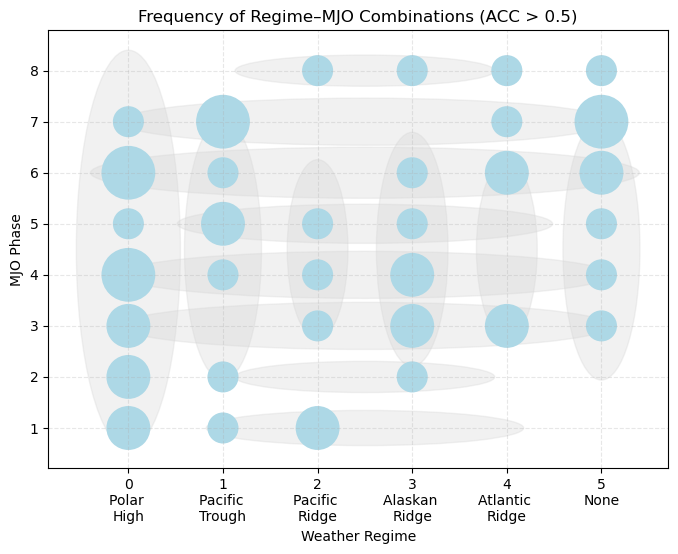

In [7]:
# Filter data where ACC > 0.5
mask = (acc > 0.6) & (enso > 1)
regimes = regime[mask]
mjophases = mjo[mask]

labels = ["0\nPolar \nHigh",
    "1\nPacific \nTrough",
    "2\nPacific \nRidge",
    "3\nAlaskan \nRidge",
    "4\nAtlantic \nRidge",
    "5\nNone"]

# Create 2D histogram (counts for each combination)
counts = np.zeros((6, 8))  # 6 regimes (0–5), 8 phases (1–8)
for r, m in zip(regimes, mjophases):
    counts[r, m - 1] += 1  # m-1 to make y=1..8 into index 0..7

# Create scatter plot
x, y = np.meshgrid(np.arange(6), np.arange(1, 9))  # x: 0–5, y: 1–8
x = x.flatten()
y = y.flatten()
sizes = counts.T.flatten() * 500  # Scale dot size
plt.figure(figsize=(8, 6))


from matplotlib.patches import Ellipse
# Sum over MJO phases for each weather regime
regime_totals = counts.sum(axis=1)  # shape: (6,)
# Add ellipses for each regime
ax = plt.gca()  # Get current axis
for i, total in enumerate(regime_totals):
    width = 0.8
    height = 7.5  # Covers most of the MJO range (1–8)
    size_scale = total / regime_totals.max() if regime_totals.max() > 0 else 0
    ellipse = Ellipse((i, 4.5),  # x=center of regime, y=center of full y-range (1–8)
        width=width * size_scale + 0.3,
        height=height * size_scale + 0.3,
        color='lightgray',
        alpha=0.3,
        zorder=0)  # Behind the scatter dots
    ax.add_patch(ellipse)
    
# Sum over regimes for each MJO phase
mjo_totals = counts.sum(axis=0)  # shape: (8,)
# Add ellipses for each MJO phase
for j, total in enumerate(mjo_totals):
    width = 5.5  # Spans across regimes 0–5
    height = 0.7
    size_scale = total / mjo_totals.max() if mjo_totals.max() > 0 else 0
    ellipse = Ellipse((2.5, j + 1),  # x=center of regime range, y=MJO phase (1–8)
        width=width * size_scale + 0.3,
        height=height * size_scale + 0.3,
        color='lightgray',
        alpha=0.3,
        zorder=0)  # Behind the scatter dots
    ax.add_patch(ellipse)
    
plt.scatter(x, y, s=sizes, c='lightblue', edgecolors='none')
plt.xlabel('Weather Regime')
plt.ylabel('MJO Phase')
plt.title('Frequency of Regime–MJO Combinations (ACC > 0.5)')
plt.xticks(ticks=range(6), labels=labels)
plt.yticks(range(1, 9))
plt.grid(True, linestyle='--', alpha=0.3)
plt.subplots_adjust(bottom=0.15)  # Adjust as needed
# plt.savefig("scatter_test_combined_factors"+".png", dpi=300)
plt.show()

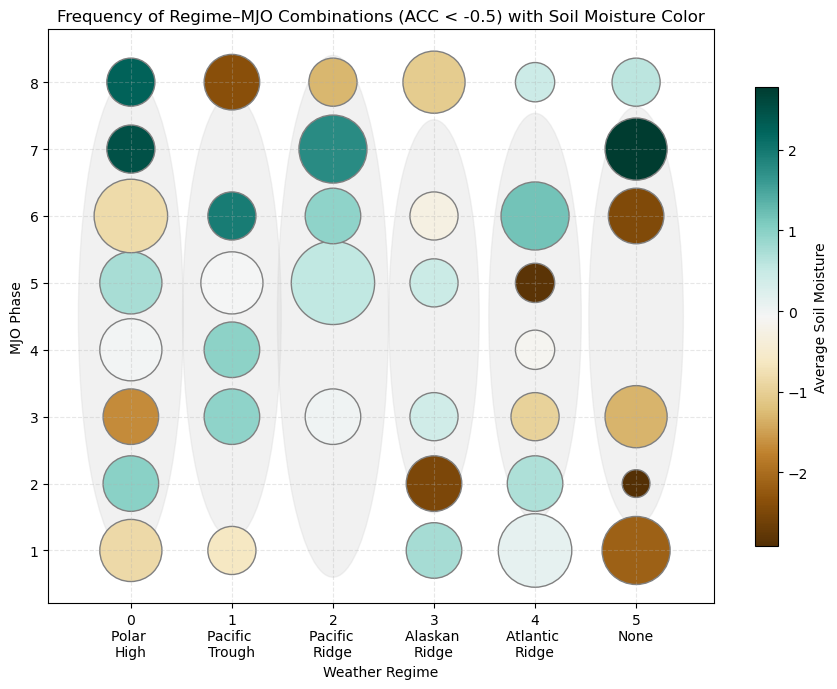

In [106]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

# Assuming you already have:
# time, acc, regime, mjo, soil arrays defined, plus:
# counts = 2D histogram counts for regime (0–5) x mjo (1–8) where acc > 0.5

mask = (acc < -0.5) & (enso > 1.2)
regimes_sel = regime[mask]
mjophases_sel = mjo[mask]
soil_sel = soil[mask]

# Calculate average soil moisture per (regime, mjo) combo
soil_means = np.full((6, 8), np.nan)
for r in range(6):
    for m in range(1, 9):
        values = soil_sel[(regimes_sel == r) & (mjophases_sel == m)]
        if len(values) > 0:
            soil_means[r, m - 1] = np.mean(values)

# Prepare grid for scatter
x, y = np.meshgrid(np.arange(6), np.arange(1, 9))
x = x.flatten()
y = y.flatten()

# Flatten counts and soil_means (transpose so MJO phases correspond to y-axis)
sizes = counts.T.flatten() * 400
colors = soil_means.T.flatten()

fig, ax = plt.subplots(figsize=(9, 7))

# Add regime ellipses behind dots (optional, as before)
regime_totals = counts.sum(axis=1)
for i, total in enumerate(regime_totals):
    width = 0.8
    height = 7.5
    size_scale = total / regime_totals.max() if regime_totals.max() > 0 else 0
    ellipse = Ellipse(
        (i, 4.5),
        width=width * size_scale + 0.3,
        height=height * size_scale + 0.3,
        color='lightgray',
        alpha=0.3,
        zorder=0)
    ax.add_patch(ellipse)

# Scatter plot: size = counts, color = avg soil moisture
sc = ax.scatter(x, y, s=sizes, c=colors, cmap='BrBG', edgecolors='gray', zorder=1)

# Axis labels and ticks
ax.set_xlabel('Weather Regime')
ax.set_ylabel('MJO Phase')
ax.set_xticks(range(6))
ax.set_yticks(range(1, 9))
ax.set_title('Frequency of Regime–MJO Combinations (ACC < -0.5) with Soil Moisture Color')

# Custom x tick labels (your multi-line regime labels)
labels = [
    "0\nPolar \nHigh",
    "1\nPacific \nTrough",
    "2\nPacific \nRidge",
    "3\nAlaskan \nRidge",
    "4\nAtlantic \nRidge",
    "5\nNone"
]
ax.set_xticklabels(labels)

# Grid and layout
ax.grid(True, linestyle='--', alpha=0.3)

# Add colorbar for soil moisture
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
cbar.set_label('Average Soil Moisture')

plt.tight_layout()
plt.savefig("scatter_test_combined_factors_3"+".png", dpi=300)
plt.show()


In [51]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

fileSIM = '/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/data/tas_2m_anom_cesm2cam6v2.scenario1_s2s_data.nc'
ds = xr.open_dataset(fileSIM)
initSIM = pd.to_datetime(ds['date'], format='%Y%m%d')

file = '/glade/work/sglanvil/CCR/S2S_windowsOfOpportunity/indices/rmm_index_cesm2cam6v2_ALL.nc'
ds = xr.open_dataset(file, decode_times=False)
raw_time = ds['time'].values
initMJO = pd.to_datetime(raw_time, unit='D', origin=pd.Timestamp('1970-01-01 12:00:00'))
ds = ds.assign_coords(time=initMJO)
rmm1_sel = ds['rmm1'].mean(dim='member').isel(lead=0) 
rmm2_sel = ds['rmm2'].mean(dim='member').isel(lead=0) 
MJOprop = np.arctan2(rmm1_sel, rmm2_sel)
edges = np.array([-np.pi,
    -3*np.pi/4,
    -np.pi/2,
    -np.pi/4,
    0,
    np.pi/4,
    np.pi/2,
    3*np.pi/4,
    np.pi])
phases = np.arange(1, 9)
MJOphase = np.digitize(MJOprop, edges[1:], right=True) + 1
common_dates = initMJO.intersection(initSIM)
idx_in_MJO = initMJO.get_indexer(common_dates)
idx_in_SIM = initSIM.get_indexer(common_dates)
MJOphaseFinal = MJOphase[idx_in_MJO]

nino34_data = []
with open('/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/data/nino34_obs.txt', 'r') as file:
    for line in file:
        values = line.split()
        nino34_data.extend(map(float, values[1:]))
enso = np.array(nino34_data)
enso = enso - enso.mean(axis=0)
dateArrayENSO = pd.date_range(start='1999-01', periods=264, freq='MS')
enso_series = pd.Series(data=enso, index=dateArrayENSO)
# enso_on_initSIM = enso_series.reindex(initSIM, method='nearest')
enso_on_initSIM = enso_series.reindex(enso_series.index.union(initSIM)).interpolate('time').loc[initSIM]
# plt.figure(figsize=(12,5))
# plt.plot(dateArrayENSO, enso,label='original ENSO (monthly)',color='blue')
# plt.plot(initSIM, enso_on_initSIM.values,'o',label='Interpolated ENSO on initSIM',color='red',markersize=4)
# plt.title('ENSO Time Series and Interpolated Values')
# plt.xlabel('Date')
# plt.ylabel('ENSO Index (Nino3.4 Anomaly)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# # plt.xlim(pd.Timestamp('2003-01-01'), pd.Timestamp('2004-12-31'))
# plt.show()

file = '/glade/work/sglanvil/CCR/S2S_windowsOfOpportunity/indices/df_labels_nocorrfilt_ERA5.csv'
df = pd.read_csv(file, skiprows=1, names=['date', 'WR', 'distances', 'corr'], parse_dates=['date'])
labels = ["0\nPolar \nHigh",
    "1\nPacific \nTrough",
    "2\nPacific \nRidge",
    "3\nAlaskan \nRidge",
    "4\nAtlantic \nRidge",
    "5\nNone"]

region_groups = {'South': ['Kansas', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana', 'Mississippi'],
    'Southwest': ['Colorado', 'Arizona', 'Utah', 'New Mexico'],
    'West': ['California', 'Nevada'],
    'Northwest': ['Washington', 'Oregon', 'Idaho'],
    'RockiesPlains': ['Montana', 'Wyoming', 'North Dakota', 'South Dakota', 'Nebraska'],
    'UpperMidwest': ['Minnesota', 'Iowa', 'Wisconsin', 'Michigan'],
    'OhioValley': ['Missouri', 'Illinois', 'Indiana', 'Ohio', 'West Virginia', 'Kentucky', 'Tennessee'],
    'Southeast': ['Alabama', 'Georgia', 'Florida', 'South Carolina', 'North Carolina', 'Virginia'],
    'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'New York', 'Pennsylvania', 'Maryland', 
                  'Delaware', 'New Jersey', 'Connecticut', 'Rhode Island', 'Massachusetts', 'District of Columbia']}
ds = xr.open_zarr("2mT_ACC_week3_byRegion_data.zarr")
for region_name in region_groups:
    R = ds[region_name]
    df_R = pd.DataFrame({'date': initSIM, 'R': R.values})
    merged = pd.merge(df[['date', 'WR']], df_R, on='date', how='inner')
    df_mjo = pd.DataFrame({'date': common_dates, 'MJOphase': MJOphaseFinal})
    merged = pd.merge(merged, df_mjo, on='date', how='inner')
    df_enso = pd.DataFrame({'date': initSIM, 'ENSO': enso_on_initSIM.values})
    merged = pd.merge(merged, df_enso, on='date', how='inner')
    merged = merged[['date', 'WR', 'MJOphase', 'ENSO', 'R']]
    assert all(merged['date'] == pd.to_datetime(merged['date']))
    assert not merged.isnull().any().any()
    
    # filtered = merged[merged['R'] > 0.5] # -------- SPECIFY
    # counts = filtered.groupby(['WR', 'MJOphase']).size().reset_index(name='count')
    # total_counts_wr = filtered.groupby('WR').size()
    # total_counts_mjo = filtered.groupby('MJOphase').size()
    # x = counts['WR']
    # y = counts['MJOphase']
    # sizes = counts['count'] * 200  # scale factor for dot sizes, adjust as needed
    # plt.figure(figsize=(7, 8))
    # ax = plt.gca()
    # max_wr = total_counts_wr.max() if len(total_counts_wr) > 0 else 1
    # max_mjo = total_counts_mjo.max() if len(total_counts_mjo) > 0 else 1
    # for wr, total in total_counts_wr.items():
    #     size_scale = total / max_wr
    #     height = 7.5 * size_scale
    #     ax.bar(wr, height, width=0.5, bottom=4.5 - height/2, color='skyblue' if total == max_wr else 'lightgray', 
    #            alpha=0.8 if total == max_wr else 0.4, zorder=1, edgecolor='gray' if total == max_wr else 'none')
    # for mjo_phase, total in total_counts_mjo.items():
    #     size_scale = total / max_mjo
    #     width = 5.5 * size_scale
    #     ax.barh(mjo_phase, width, height=0.5, left=2.5 - width/2, color='skyblue' if total == max_mjo else 'lightgray', 
    #             alpha=0.8 if total == max_mjo else 0.4, zorder=1, edgecolor='gray' if total == max_mjo else 'none')
    # scatter = plt.scatter(x, y, s=sizes, alpha=1, edgecolors='gray', color='skyblue', zorder=2)
    # ax.set_ylabel('MJO Phase', fontweight='bold', labelpad=10)
    # ax.set_xlabel('Weather Regime', fontweight='bold', labelpad=10)
    # ax.set_xticks(ticks=range(0, 6), labels=labels)
    # ax.set_yticks(ticks=range(1, 9))
    # ax.set_title('Count of ACC<-0.25 for 2mT Week 3 (' + region_name + ')', fontweight='bold')
    # ax.set_ylim(0, 9)
    # ax.set_xlim(-1, 6)
    # ax.grid(True, linestyle='--', alpha=0.5)
    # for _, row in counts.iterrows():
    #     ax.text(row['WR'], row['MJOphase'], int(row['count']), ha='center', va='center', fontsize=8, color='black', zorder=3)
    # # plt.savefig("2mT_ACC_week3_combined_factors_ACCltneg025_"+ region_name +".png", dpi=300)
    # plt.show()

    # ----------------------- forward composite -----------------------
    accWant = 0.5
    acc = merged['R']
    regime = merged['WR']
    mjo = merged['MJOphase']
    enso = merged['ENSO']
    num_events = np.sum(acc > accWant)
    regime_capture = np.bincount(regime[acc > accWant]).argmax()
    mjo_capture = np.bincount(mjo[acc > accWant]).argmax()
    enso_capture = enso[acc > accWant].mean()
    print("\n"+region_name)
    print("------------------------------------------------------------------")
    print("------ Forward Analysis [ie, what indices are doing when ACC>0.5]")
    print("Number of Matches:", num_events)
    print("Weather Regime:", regime_capture)
    print("MJO phase:", mjo_capture)
    print("ENSO phase: {:.2f}".format(enso_capture))

    mask = ( (regime == regime_capture) & (np.abs(mjo-mjo_capture)<=1) &  (np.abs(enso-enso_capture)<=1))
    acc_filtered = acc[mask]
    print("------ Reverse Analysis [ie, avg ACC when conditions are met]")
    print("Number of Matches:", np.sum(mask))
    print("Average ACC for matched conditions:", np.round(acc_filtered.mean(), 3))
    print("------------------------------------------------------------------")
    print()




South
------------------------------------------------------------------
------ Forward Analysis [ie, what indices are doing when ACC>0.5]
Number of Matches: 331
Weather Regime: 2
MJO phase: 3
ENSO phase: -0.03
------ Reverse Analysis [ie, avg ACC when conditions are met]
Number of Matches: 82
Average ACC for matched conditions: 0.201
------------------------------------------------------------------


Southwest
------------------------------------------------------------------
------ Forward Analysis [ie, what indices are doing when ACC>0.5]
Number of Matches: 217
Weather Regime: 1
MJO phase: 3
ENSO phase: -0.03
------ Reverse Analysis [ie, avg ACC when conditions are met]
Number of Matches: 77
Average ACC for matched conditions: 0.089
------------------------------------------------------------------


West
------------------------------------------------------------------
------ Forward Analysis [ie, what indices are doing when ACC>0.5]
Number of Matches: 254
Weather Regime: 1
MJO 

In [ ]:

# for wr, total in total_counts_wr.items():
    #     size_scale = total / max_wr
    #     ellipse_width = 0.8
    #     ellipse_height = 7.5 * size_scale
    #     color = 'skyblue' if total == max_wr else 'lightgray'
    #     ellipse = Ellipse((wr, 4.5), width=ellipse_width, height=ellipse_height, color=color, alpha=0.5, zorder=1)
    #     ax.add_patch(ellipse)
    # for mjo_phase, total in total_counts_mjo.items():
    #     size_scale = total / max_mjo
    #     ellipse_width = 5.5 * size_scale
    #     ellipse_height = 0.8
    #     color = 'skyblue' if total == max_mjo else 'lightgray'
    #     ellipse = Ellipse((2.5, mjo_phase), width=ellipse_width, height=ellipse_height, color=color, alpha=0.5, zorder=1)
    #     ax.add_patch(ellipse)
